Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm1_t6_43M_UR50S.pt" to /home/suhyun/.cache/torch/hub/checkpoints/esm1_t6_43M_UR50S.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm1_t6_43M_UR50S-contact-regression.pt" to /home/suhyun/.cache/torch/hub/checkpoints/esm1_t6_43M_UR50S-contact-regression.pt


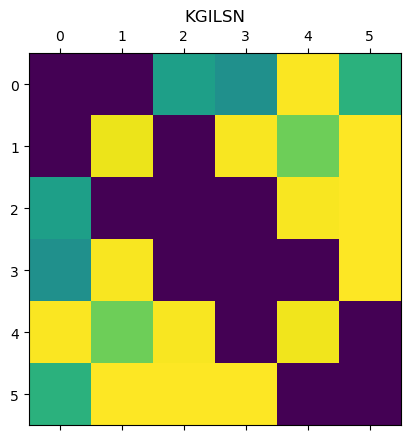

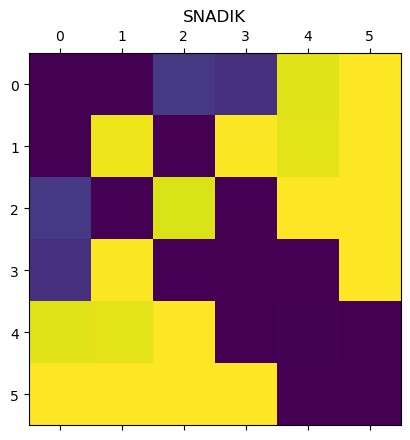

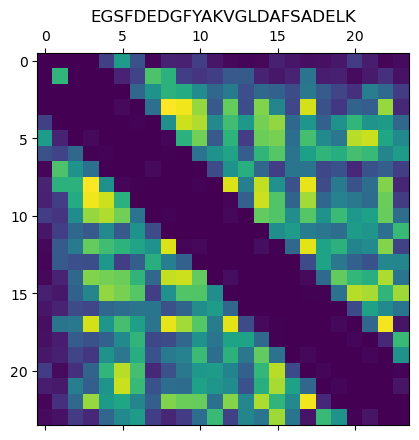

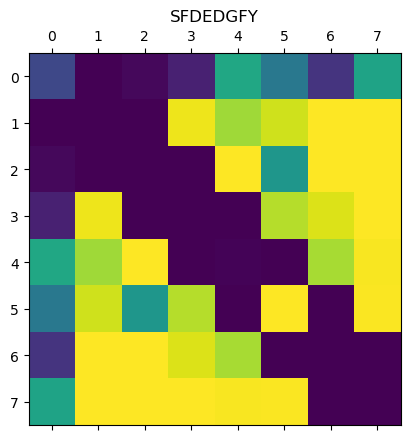

tensor([[32, 15,  6, 12,  4,  8, 17,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1],
        [32,  8, 17,  5, 13, 12, 15,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1],
        [32,  9,  6,  8, 18, 13,  9, 13,  6, 18, 19,  5, 15,  7,  6,  4, 13,  5,
         18,  8,  5, 13,  9,  4, 15],
        [32,  8, 18, 13,  9, 13,  6, 18, 19,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1]])
['1', '2', '3', '4']
['KGILSN', 'SNADIK', 'EGSFDEDGFYAKVGLDAFSADELK', 'SFDEDGFY']
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])


In [1]:
import torch
import esm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# Load ESM-1b model
model, alphabet = esm.pretrained.esm1_t6_43M_UR50S()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [
    ("1", "KGILSN"),
    ("2", "SNADIK"),
    ("3","EGSFDEDGFYAKVGLDAFSADELK"),
    ("4",  "SFDEDGFY"),
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[6], return_contacts=True)
token_representations = results["representations"][6]

# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
sequence_representations = []
for i, (_, seq) in enumerate(data):
    sequence_representations.append(token_representations[i, 1 : len(seq) + 1].mean(0))

# Look at the unsupervised self-attention map contact predictions
import matplotlib.pyplot as plt
for (_, seq), attention_contacts in zip(data, results["contacts"]):
    plt.matshow(attention_contacts[: len(seq), : len(seq)])
    plt.title(seq)
    plt.show()

print(batch_tokens)
print(batch_labels)
print(batch_strs)
for seq in sequence_representations:
    print(seq.shape)

In [1]:
import random
import pandas as pd
import numpy as np
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import esm

from tqdm import tqdm
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
CFG = {
    'NUM_WORKERS':4, ## 4
    'ANTIGEN_WINDOW':128,
    'ANTIGEN_MAX_LEN':128, # ANTIGEN_WINDOW와 ANTIGEN_MAX_LEN은 같아야합니다.
    'EPITOPE_MAX_LEN':256,
    'EPOCHS':1000,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':64,
    'THRESHOLD':0.5,
    'SEED':41
}

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [6]:
def get_preprocessing(data_type, new_df):
    alpha_map = {
                'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5,
                'G':6, 'H':7, 'I':8, 'J':9, 'K':10, 'L':11,
                'M':12, 'N':13, 'O':14, 'P':15, 'Q':16, 'R':17,
                'S':18, 'T':19, 'U':20, 'V':21, 'W':22, 'X':23,
                'Y':24, 'Z':25, '<PAD>':26,
            }
    
    epitope_seq_list = []
    epitope_list = []
    left_antigen_list = []
    right_antigen_list = []
    
    for epitope, antigen, s_p, e_p in tqdm(zip(new_df['epitope_seq'], new_df['antigen_seq'], new_df['start_position'], new_df['end_position'])):
        epitope_pad = [26 for _ in range(CFG['EPITOPE_MAX_LEN'])]
        left_antigen_pad = [26 for _ in range(CFG['ANTIGEN_MAX_LEN'])]
        right_antigen_pad = [26 for _ in range(CFG['ANTIGEN_MAX_LEN'])]
        
        epitope_seq = epitope
        epitope = [alpha_map[x] for x in epitope]
        
        # Left antigen : [start_position-WINDOW : start_position]
        # Right antigen : [end_position : end_position+WINDOW]

        start_position = s_p-CFG['ANTIGEN_WINDOW']-1
        end_position = e_p+CFG['ANTIGEN_WINDOW']
        if start_position < 0:
            start_position = 0
        if end_position > len(antigen):
            end_position = len(antigen)
        
        # left / right antigen sequence 추출
        left_antigen = antigen[int(start_position) : int(s_p)-1]
        left_antigen = [alpha_map[x] for x in left_antigen]
        
        right_antigen = antigen[int(e_p) : int(end_position)]
        right_antigen = [alpha_map[x] for x in right_antigen]

        if CFG['EPITOPE_MAX_LEN']<len(epitope):
            epitope_pad[:len(epitope)] = epitope[:CFG['EPITOPE_MAX_LEN']]
        else:
            epitope_pad[:len(epitope)] = epitope[:]

        left_antigen_pad[:len(left_antigen)] = left_antigen[:]
        right_antigen_pad[:len(right_antigen)] = right_antigen[:]
        
        epitope_seq_list.append(epitope_seq)
        epitope_list.append(epitope_pad)
        left_antigen_list.append(left_antigen_pad)
        right_antigen_list.append(right_antigen_pad)
        
    label_list = None
    if data_type != 'test':
        label_list = []
        for label in new_df['label']:
            label_list.append(label)
    print(f'{data_type} dataframe preprocessing was done.')
    return epitope_seq_list, epitope_list, left_antigen_list, right_antigen_list, label_list

In [7]:
all_df = pd.read_csv('./data/train.csv')
# Split Train : Validation = 0.8 : 0.2
train_len = len(all_df)
train_idx = np.arange(train_len)
train_df = all_df.iloc[train_idx[:int(train_len*0.8)]]
val_df = all_df.iloc[train_idx[int(train_len*0.8):]]

In [8]:
train_epitope_seq_list, train_epitope_list, train_left_antigen_list, train_right_antigen_list, train_label_list = get_preprocessing('train', train_df)
val_epitope_seq_list, val_epitope_list, val_left_antigen_list, val_right_antigen_list, val_label_list = get_preprocessing('val', val_df)

152648it [00:06, 23212.21it/s]


train dataframe preprocessing was done.


38163it [00:01, 32798.50it/s]

val dataframe preprocessing was done.


In [9]:
class CustomDataset(Dataset):
    def __init__(self, epitope_seq_list, epitope_list, left_antigen_list, right_antigen_list, label_list):
        self.epitope_seq_list = epitope_seq_list
        self.epitope_list = epitope_list
        self.left_antigen_list = left_antigen_list
        self.right_antigen_list = right_antigen_list
        self.label_list = label_list
        
    def __getitem__(self, index):
        self.epitope_seq = self.epitope_seq_list[index]
        self.epitope = self.epitope_list[index]
        self.left_antigen = self.left_antigen_list[index]
        self.right_antigen = self.right_antigen_list[index]
        
        if self.label_list is not None:
            self.label = self.label_list[index]
            return self.epitope_seq, torch.tensor(self.epitope), torch.tensor(self.left_antigen), torch.tensor(self.right_antigen), self.label
        else:
            return self.epitope_seq, torch.tensor(self.epitope), torch.tensor(self.left_antigen), torch.tensor(self.right_antigen)
        
    def __len__(self):
        return len(self.epitope_list)

In [10]:
train_dataset = CustomDataset(train_epitope_seq_list, train_epitope_list, train_left_antigen_list, train_right_antigen_list, train_label_list)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=CFG['NUM_WORKERS'])

val_dataset = CustomDataset(val_epitope_seq_list, val_epitope_list, val_left_antigen_list, val_right_antigen_list, val_label_list)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=CFG['NUM_WORKERS'])

In [11]:
class Classifier(nn.Module):
    def __init__(self,in_channels):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.LeakyReLU(True),
            nn.BatchNorm1d(in_channels),
            nn.Linear(in_channels, in_channels//4),
            nn.LeakyReLU(True),
            nn.BatchNorm1d(in_channels//4),
            nn.Linear(in_channels//4, 1)
        )
        
    def forward(self, x):
        x = self.classifier(x).view(-1)
        return x

In [12]:
def train(model_esm43, batch_converter, classifier, optimizer, train_loader, val_loader, scheduler, device):
    model_esm43.to(device)
    classifier.to(device)
    criterion = nn.BCEWithLogitsLoss().to(device) 
    
    best_val_f1 = 0
    for epoch in range(1, CFG['EPOCHS']+1):
        model_esm43.train()
        classifier.train()
        train_loss = []
        for epitope_char_seq, epitope_seq, left_antigen_seq, right_antigen_seq, label in tqdm(iter(train_loader)):
            label = label.float().to(device)
            optimizer.zero_grad()
            
            batch_data = [(str(i+1), d) for i, d in enumerate(epitope_char_seq)]
            batch_labels, batch_strs, batch_tokens = batch_converter(batch_data)
            batch_tokens = batch_tokens.to(device)
            results = model_esm43(batch_tokens, repr_layers=[6], return_contacts=True)
            token_representations = results["representations"][6]
            sequence_representations = torch.tensor([]).to(device)
            for i, (_, seq) in enumerate(batch_data):
                sequence_representations = torch.cat((sequence_representations, token_representations[i, 1 : len(seq) + 1].mean(0)), 0)
            sequence_representations = sequence_representations.reshape(len(batch_data),-1)
            sequence_representations = torch.tensor(sequence_representations).to(device)
            output = classifier(sequence_representations)
            loss = criterion(output, label)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            
            if scheduler is not None:
                scheduler.step()
                    
        val_loss, val_f1, val_acc, val_precision, val_recall, val_conf = validation(model_esm43, batch_converter, classifier, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}] Val F1 : [{val_f1:.5f}] Val ACC : [{val_acc:.5f}] ')
        print(f'                                   Val Precision : [{val_precision:.5f}] Val Recall : [{val_recall:.5f}]')
        print(val_conf)
        
        if best_val_f1 < val_f1:
            best_val_f1 = val_f1
            torch.save(model_esm43.state_dict(), './best_model_esm43.pth', _use_new_zipfile_serialization=False)
            torch.save(classifier.state_dict(), './best_model_esm43_classifier.pth', _use_new_zipfile_serialization=False)
            print('Model Saved.')
    return best_val_f1

In [13]:
def validation(model_esm43, batch_converter, classifier, val_loader, criterion, device):
    model_esm43.eval()
    classifier.eval()
    pred_proba_label = []
    true_label = []
    val_loss = []
    with torch.no_grad():
        for epitope_char_seq, epitope_seq, left_antigen_seq, right_antigen_seq, label in tqdm(iter(val_loader)):
            label = label.float().to(device)
            
            batch_data = [(str(i+1), d) for i, d in enumerate(epitope_char_seq)]
            batch_labels, batch_strs, batch_tokens = batch_converter(batch_data)
            batch_tokens = batch_tokens.to(device)
            results = model_esm43(batch_tokens, repr_layers=[6], return_contacts=True)
            token_representations = results["representations"][6]
            sequence_representations = torch.tensor([]).to(device)
            for i, (_, seq) in enumerate(batch_data):
                sequence_representations = torch.cat((sequence_representations, token_representations[i, 1 : len(seq) + 1].mean(0)), 0)

            sequence_representations = sequence_representations.reshape(len(batch_data),-1)
            sequence_representations = torch.tensor(sequence_representations).to(device)
            output = classifier(sequence_representations)
            loss = criterion(output, label)
            
            model_pred = torch.sigmoid(output).to('cpu')
            
            pred_proba_label += model_pred.tolist()
            true_label += label.to('cpu').tolist()
            
            val_loss.append(loss.item())
    
    pred_label = np.where(np.array(pred_proba_label)>CFG['THRESHOLD'], 1, 0)
    val_f1        = f1_score(true_label, pred_label, average='macro')
    val_confusion = confusion_matrix(true_label, pred_label)
    val_acc       = accuracy_score(true_label, pred_label)
    val_precision = precision_score(true_label, pred_label)
    val_recall    = recall_score(true_label, pred_label)
    return np.mean(val_loss), val_f1, val_acc, val_precision, val_recall, val_confusion

In [14]:
model_esm43, alphabet = esm.pretrained.esm1_t6_43M_UR50S()
batch_converter = alphabet.get_batch_converter()
classifier = Classifier(in_channels=768)

# model_esm43 = nn.parallel.DistributedDataParallel(model_esm43)
# classifier = nn.parallel.DistributedDataParallel(classifier)

model_esm43.eval()
classifier.eval()
optimizer = torch.optim.Adam([{'params':model_esm43.parameters()}, {'params':classifier.parameters()}], lr = CFG["LEARNING_RATE"])
# optimizer = torch.optim.Adam((list(model.parameters()) + list(model_seqvec.parameters())), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader)*CFG['EPOCHS'], eta_min=0)
best_score = train(model_esm43, batch_converter, classifier, optimizer, train_loader, val_loader, scheduler, device)
print(f'Best Validation F1 Score : [{best_score:.5f}]')

 67%|██████▋   | 1607/2386 [00:48<00:23, 32.90it/s]


RuntimeError: CUDA out of memory. Tried to allocate 190.00 MiB (GPU 0; 10.76 GiB total capacity; 8.92 GiB already allocated; 87.69 MiB free; 9.51 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
test_df = pd.read_csv('./data/test.csv')
test_epitope_seq_list,test_epitope_list, test_left_antigen_list, test_right_antigen_list,test_label_list = get_preprocessing('test', test_df)

In [ ]:
test_dataset = CustomDataset(test_epitope_seq_list, test_epitope_list, test_left_antigen_list, test_right_antigen_list, None)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=CFG['NUM_WORKERS'])

In [ ]:
model_esm43, alphabet = esm.pretrained.esm1_t6_43M_UR50S()
batch_converter = alphabet.get_batch_converter()
# model_esm43 = nn.parallel.DistributedDataParallel(model_esm43)
best_model_esm43_checkpoint = torch.load('./best_model_esm43.pth')
best_model_esm43_checkpoint = {'module.'+k: v for k, v in best_model_esm43_checkpoint.items() if k in best_model_esm43_checkpoint}
model_esm43.load_state_dict(best_model_esm43_checkpoint)
model_esm43.eval()

classifier = Classifier(in_channels=768)
# classifier = nn.parallel.DistributedDataParallel(classifier)
best_model_classifier_checkpoint = torch.load('./best_model_seqvec_classifier.pth')
classifier.load_state_dict(best_model_classifier_checkpoint)
classifier.eval()
classifier.to(device)

In [ ]:
def inference(model_esm43, batch_converter, classifier, test_loader, device):
    model_esm43.eval()
    classifier.eval()
    pred_proba_label = []
    with torch.no_grad():
        for epitope_char_seq, epitope_seq, left_antigen_seq, right_antigen_seq in tqdm(iter(test_loader)):
            batch_data = [(str(i+1), d) for i, d in enumerate(epitope_char_seq)]
            batch_labels, batch_strs, batch_tokens = batch_converter(batch_data)
            batch_tokens = batch_tokens.to(device)
            results = model_esm43(batch_tokens, repr_layers=[6], return_contacts=True)
            token_representations = results["representations"][6]
            sequence_representations = torch.tensor([]).to(device)
            for i, (_, seq) in enumerate(batch_data):
#                 sequence_representations.append(token_representations[i, 1 : len(seq) + 1].mean(0))
                 sequence_representations = torch.cat((sequence_representations, token_representations[i, 1 : len(seq) + 1].mean(0)), 0)

            sequence_representations = sequence_representations.reshape(len(batch_data),-1)
            sequence_representations = torch.tensor(sequence_representations).to(device)
            output = classifier(sequence_representations)

            model_pred = torch.sigmoid(output).to('cpu')
            pred_proba_label += model_pred.tolist()

    pred_label = np.where(np.array(pred_proba_label)>CFG['THRESHOLD'], 1, 0)
    return pred_label

In [ ]:
preds = inference(model_esm43, batch_converter, classifier, test_loader, device)

In [ ]:
submit = pd.read_csv('./test/sample_submission.csv')
submit['label'] = preds

In [ ]:
submit.to_csv('./ESM_43.csv', index=False)
print('Done.')